In [1]:
#lets import the torch library
import torch
#first of let us check if There is any GPU so that we could use that for training
if torch.cuda.is_available():
    # let us set the device to GPU if available
    device = torch.device('cuda')
    print('The GPU is there and ready to use')
else:
    # let us set the device to CPU as if no GPu
    device = torch.device('cpu')
    print('Using the CPU as there is no any GPU avialble')

The GPU is there and ready to use


In [2]:
#importinf the neccessary library to read the data
import pandas as pd
import numpy as np
#let us import matplot for plotting
import matplotlib.pyplot as plt
import seaborn as sns
#lets import nltk in order to remove the stopwords
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import csv
from tensorflow.keras.preprocessing.text import Tokenizer
#lets import pad_sequences in order to pad the sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import torch
import torch.nn as nn
import torch.optim as optim
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
#let us import the Word2Vec for embedding the words
from gensim.models import Word2Vec

In [3]:
# we will be Importing the drive module from the google.colab library as our data is on the google drive.
from google.colab import drive
#Let us mount the drive so that we can access the dataset
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
#let us load the yelp review polarity data from the drive named as train.csv
koushik_yelp_data = '/content/drive/MyDrive/DLProject/train.csv'

In [10]:
#with the help of the CSV module by custom parse function we will be loading the dataset
with open(koushik_yelp_data, 'r') as file:
    reader = csv.reader(file)
    data = [row for row in reader]

In [11]:
# let us load our data as dataframe and assign the the respective column names
yelp_koushik_data = pd.DataFrame(data[1:], columns=['class', 'review_text'])
#let us display the shape of the data
yelp_koushik_data.shape

(559999, 2)

In [12]:
#Let us filter our data by using the first 1 lakh roww=s of each class so that we,
# cannot get any kernel breakage issues
class1_yelp = yelp_koushik_data[yelp_koushik_data['class'] == '1'].index[:50000]
class2_yelp = yelp_koushik_data[yelp_koushik_data['class'] == '2'].index[:50000]
#let us join the 2 classes
filtered_data_yelp = class1_yelp.union(class2_yelp)
yelp_filtr_data = yelp_koushik_data.loc[filtered_data_yelp]


In [13]:
#let us check the unique counts of each class in the dataset
yelp_filtr_data['class'].value_counts()

class
2    50000
1    50000
Name: count, dtype: int64

In [14]:
# conversion of class column as int
yelp_filtr_data['class'] = yelp_filtr_data['class'].astype(int)
yelp_filtr_data.dtypes

class           int64
review_text    object
dtype: object

In [15]:
#let us replace class labels 1 with 0
yelp_filtr_data['class'] = yelp_filtr_data['class'].replace(1, 0)
#let us replace class labels 2 with 1
yelp_filtr_data['class'] = yelp_filtr_data['class'].replace(2, 1)
#let us check the counts of each class
yelp_filtr_data['class'].value_counts()

class
1    50000
0    50000
Name: count, dtype: int64

In [16]:
#let us display the head of our data set
yelp_filtr_data.head()

,class,review_text
0,1,Been going to Dr. Goldberg for over 10 years. ...
1,0,I don't know what Dr. Goldberg was like before...
2,0,I'm writing this review to give you a heads up...
3,1,All the food is great here. But the best thing...
4,0,Wing sauce is like water. Pretty much a lot of...


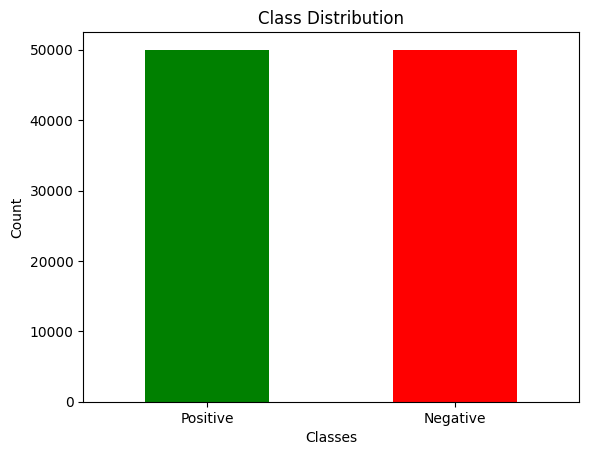

In [55]:
fig, ax = plt.subplots()
yelp_filtr_data['class'].value_counts().plot(kind='bar', color=['green', 'red'], ax=ax)
ax.set_title('Class Distribution')
ax.set_xlabel('Classes')
ax.set_ylabel('Count')
ax.set_xticklabels(['Positive', 'Negative'], rotation=0)
plt.show()


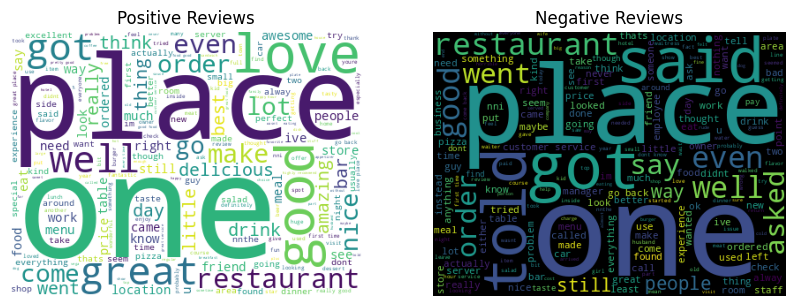

In [56]:
from wordcloud import WordCloud

positive_reviews = yelp_filtr_data[yelp_filtr_data['class'] == 1]['review_text'].str.cat(sep=' ')
negative_reviews = yelp_filtr_data[yelp_filtr_data['class'] == 0]['review_text'].str.cat(sep=' ')

pos_wordcloud = WordCloud(width=400, height=300, background_color='white').generate(positive_reviews)
neg_wordcloud = WordCloud(width=400, height=300, background_color='black').generate(negative_reviews)

# Display the word clouds
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(pos_wordcloud)
axes[0].set_title('Positive Reviews')
axes[0].axis('off')
axes[1].imshow(neg_wordcloud)
axes[1].set_title('Negative Reviews')
axes[1].axis('off')
plt.show()


<ipython-input-57-8f2869991afe>:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  yelp_filtr_data.hist(column='review_length', by='class', bins=30, ax=ax, color='blue', alpha=0.7)


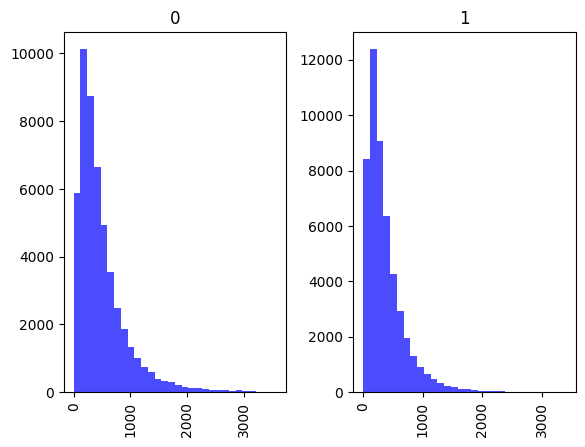

In [57]:
yelp_filtr_data['review_length'] = yelp_filtr_data['review_text'].apply(len)

# Plot histogram
fig, ax = plt.subplots()
yelp_filtr_data.hist(column='review_length', by='class', bins=30, ax=ax, color='blue', alpha=0.7)
ax.set_title('Review Length Distribution')
ax.set_xlabel('Review Length')
ax.set_ylabel('Frequency')
plt.show()

In [17]:
import re
import string
#let us download the stopwords using the nltk library
nltk.download('stopwords')
#now let us get set of the english stop words
stopwords_eng = set(stopwords.words('english'))
#let create a function in order to clean text
def textual_cleaning(text):
  #conversion of the text to the lower case
    text = text.lower()
    #punctuation removal along with special characters
    text = re.sub(r'[^\w\s]', '', text)
    #removal of the stop words
    text = ' '.join(word for word in text.split() if word not in stopwords_eng)
    return text

yelp_filtr_data['review_text'] = yelp_filtr_data['review_text'].apply(textual_cleaning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
#let us display the head of the data
yelp_filtr_data.head()

,class,review_text
0,1,going dr goldberg 10 years think one 1st patie...
1,0,dont know dr goldberg like moving arizona let ...
2,0,im writing review give heads see doctor office...
3,1,food great best thing wings wings simply fanta...
4,0,wing sauce like water pretty much lot butter h...


In [19]:
#let us intialize the tokenizer object
tokenizer = Tokenizer()
#let us tokenize the review_text colmun for creation of word-to-index mappings
tokenizer.fit_on_texts(yelp_filtr_data['review_text'])
#through count of the unique words in tokenized word index let us determine the vocuably size
vocab_size = len(tokenizer.word_index) + 1
#let us display the size of the vocuablary
print(vocab_size)
#finding the max sequence length of the caption in regards to words
max_length = max(len(caption.split()) for caption in yelp_filtr_data['review_text'])
print(max_length)

196307
505


In [20]:
#by using the tokenzier text data conversion into sequences of inetegrs
sequences = tokenizer.texts_to_sequences(yelp_filtr_data['review_text'])

In [21]:
#in order to ensure the uniform sequences let us pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [22]:
#with the help of Word2Vec let us generate the word embedings
word2vec_model = Word2Vec(sentences=sequences, vector_size=100, window=5, min_count=1, workers=4)
#Embedding matrix is first initialised with the zeroes
embedding_matrix = np.zeros((vocab_size, 100))
#embedding matrix is populated with word vectors generated by Word2Vec model
for word, idx in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[idx] = word2vec_model.wv[word]

In [23]:
#conversion of the embedding matrix to the torch tensors in order to use for the nn.Embedding layers
embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)

In [24]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=7000):
        super().__init__()
        #we are trying to generate a sequence of positions
        pos = torch.arange(max_len).unsqueeze(1)
        log_base = math.log(10000.0) / d_model
        temp = torch.arange(0, d_model, 2)
        exp = torch.exp(temp * -log_base)
        #defined a positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        #for the even indices in the matrix we are using sin
        pe[:, 0::2] = torch.sin(pos * exp)
        #and for the odd indices we are using cosine function
        pe[:, 1::2] = torch.cos(pos * exp)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
      #a forward pass function for the postional encoding
      x = x + self.pe[:, :x.size(1)]
      return x

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, num_classes,num_heads,embed_dime,hidden_dim,n_encoder_layers,n_decoder_layers):
        super().__init__()
        self.embed_dim = embed_dime
        #embedding layer that is used for converting the input tokens to vectors of the embed_dim size
        self.embedding = nn.Embedding(vocab_size, self.embed_dim)
        #calling the positional enocder function
        self.pos_encoder = PositionalEncoding(self.embed_dim)
        #defining the encoder layer of the transformer model
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.embed_dim, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_encoder_layers)
        #similarly defining the decoder layer of the transformer model
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=self.embed_dim, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=n_decoder_layers)
        #a fully connected layer from the decoder output to the total number of classes
        self.fc_out = nn.Linear(self.embed_dim, num_classes)

    def forward(self, src):
      #definined a forward pass for the transformer model
      cal = math.sqrt(self.embed_dim)
      src = self.embedding(src) * cal
      src = self.pos_encoder(src)
      mem = self.transformer_encoder(src)
      op = self.transformer_decoder(src, mem)
      op = op.mean(dim=1)
      op = self.fc_out(op)
      return op


In [25]:
#Hyperparameters
num_heads = 8
embed_dime = 256
hidden_dim = 512
n_encoder_layers = 1
n_decoder_layers = 1
num_classes=2
learning_rate = 0.0001
batch_size = 64

In [26]:
# # Initialized the model, optimizer, and loss function
model = TransformerModel(vocab_size,num_classes,num_heads,embed_dime,hidden_dim,n_encoder_layers,n_decoder_layers)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [27]:
model.to(device)

TransformerModel(
  (embedding): Embedding(196307, 256)
  (pos_encoder): PositionalEncoding()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_feature

In [28]:
#splitting the data into train, test and val
train_val_data, test_data, train_val_labels, test_labels = train_test_split(
    padded_sequences, yelp_filtr_data['class'].values, test_size=0.2, random_state=42)

train_data, val_data, train_labels, val_labels = train_test_split(
    train_val_data, train_val_labels, test_size=0.25, random_state=42)

#and converting them into torch tensors
train_data = torch.tensor(train_data, dtype=torch.long)
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_data = torch.tensor(val_data, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_data = torch.tensor(test_data, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)


In [29]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

#by using the tensor dataset and dataloader we are getting the train, test and val loaders
train_dataset = TensorDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(val_data, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

def train_test_val_cal(model,num_epochs):
  train_loss, train_accuracy, val_loss, val_accuracy = [], [], [], []
  test_accuracy = 0
  num_epochs = num_epochs
  for epoch in range(num_epochs):
      model.train() #training the resnet model
      run_loss = 0.0
      real = 0
      complete = 0
      for batch_data, batch_labels in train_loader:
        batch_data,batch_labels=batch_data.to(device),batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs.squeeze(), batch_labels)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
        _, predicted = outputs.max(1)
        complete += batch_labels.size(0)
        real += (predicted == batch_labels).sum().item()

      # Validation loop of the model
      model.eval()
      val_loss_eval = 0.0 #validation loss for the network
      correct = 0 #number of correct smaples
      total = 0 #total number of samples
      with torch.no_grad():
        for batch_data, batch_labels in val_loader:
            batch_data,batch_labels=batch_data.to(device),batch_labels.to(device)
            outputs = model(batch_data)
            loss = criterion(outputs.squeeze(), batch_labels)
            val_loss_eval += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
      #storing the values and calcualtign the corresponding loss of validaiton
      #and its accuracy as well for each epoch for the trained resnet
      #architectrue model
      epoch_train_loss = run_loss/(len(train_loader))
      epoch_train_acc = real/complete
      epoch_val_loss = val_loss_eval/(len(val_loader))
      epoch_val_acc = correct/total
      train_loss.append(epoch_train_loss)
      train_accuracy.append(epoch_train_acc)
      val_loss.append(epoch_val_loss)
      val_accuracy.append(epoch_val_acc)
      print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_train_loss}, Training Accuracy: {epoch_train_acc}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_acc}")


  #Testing
  model.eval()
  test_correct = 0 #total correct samples that it predicted correct
  test_total = 0 #total number of test samples
  test_predictions = []
  true_labels = []
  test_scores = [] #for roc curve
  with torch.no_grad():
    for batch_data, batch_labels in test_loader:
        batch_data,batch_labels=batch_data.to(device),batch_labels.to(device)
        outputs = model(batch_data)
        _, predicted = torch.max(outputs, 1)
        test_total += batch_labels.size(0)
        test_correct += (predicted == batch_labels).sum().item()
        test_predictions.extend(predicted.cpu().numpy())
        true_labels.extend(batch_labels.cpu().numpy())
        test_scores.extend(outputs.cpu().numpy())
  #calculating and printing the accuracy of the model after evaluating the model.
  test_accuracy = test_correct/test_total
  print(f"Test Accuracy: {test_correct / test_total}")


  conf_matrix = confusion_matrix(true_labels, test_predictions)
  class_report = classification_report(true_labels, test_predictions)
  return train_loss, train_accuracy, val_loss, val_accuracy, test_accuracy, conf_matrix, class_report, true_labels,test_scores

In [31]:
train_loss, train_accuracy, val_loss, val_accuracy, test_accuracy, conf_matrix, class_report, true_labels,test_scores = train_test_val_cal(model,num_epochs=5)

Epoch 1/5, Training Loss: 0.6623146212431413, Training Accuracy: 0.6007, Validation Loss: 0.6181938364482916, Validation Accuracy: 0.6611
Epoch 2/5, Training Loss: 0.5911961330660879, Training Accuracy: 0.7126333333333333, Validation Loss: 0.5601642049920444, Validation Accuracy: 0.76725
Epoch 3/5, Training Loss: 0.5411102559838468, Training Accuracy: 0.7486333333333334, Validation Loss: 0.517855110831154, Validation Accuracy: 0.75525
Epoch 4/5, Training Loss: 0.5048511933479736, Training Accuracy: 0.7696666666666667, Validation Loss: 0.489899515153501, Validation Accuracy: 0.78255
Epoch 5/5, Training Loss: 0.47759409004182957, Training Accuracy: 0.78415, Validation Loss: 0.47155750959445114, Validation Accuracy: 0.7969
Test Accuracy: 0.79805


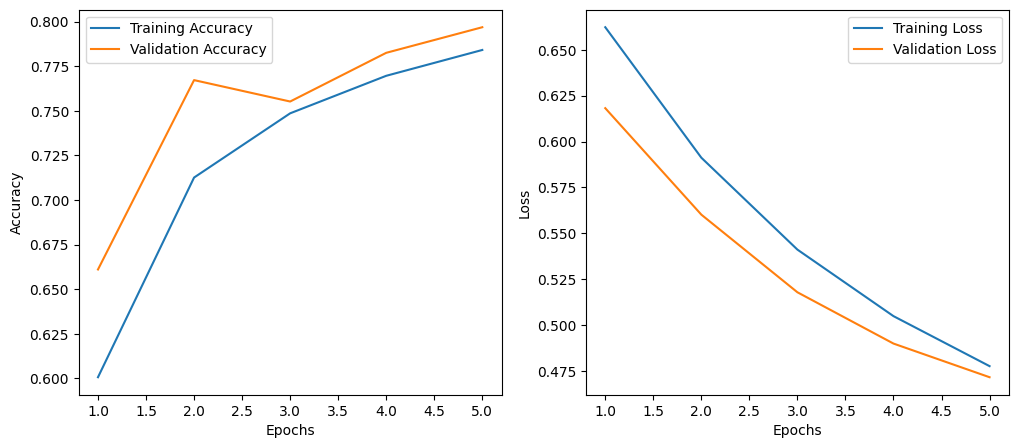

In [32]:
import matplotlib.pyplot as plt
num_epochs = 5
# Plot training and validation accuracy over time for base model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1),train_accuracy, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1),val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss over time for base model
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1),train_loss, label='Training Loss')
plt.plot(range(1, num_epochs + 1),val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


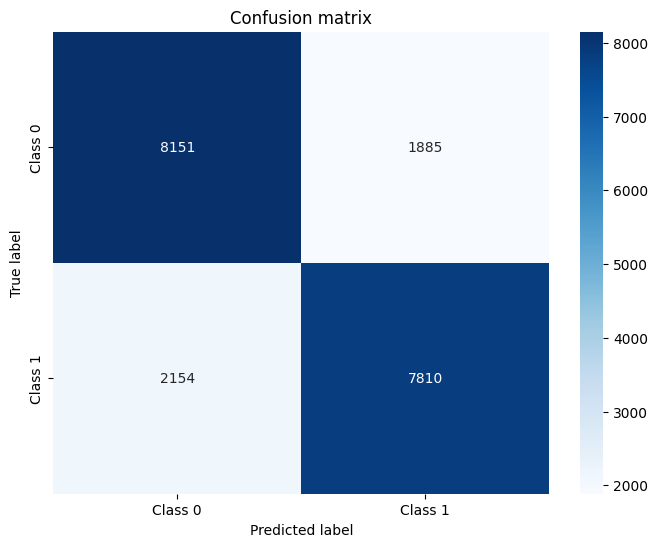

In [33]:
#confusion matrix of the base model
import seaborn as sns
plt.figure(figsize=(8, 6))
class_labels = ['Class 0', 'Class 1']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion matrix")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [34]:
#classification report of the base model
print(class_report)

              precision    recall  f1-score   support

           0       0.79      0.81      0.80     10036
           1       0.81      0.78      0.79      9964

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000



In [35]:
#for roc curve for the base model
true_labels_one_hot = label_binarize(true_labels, classes=[0, 1])
test_scores = np.array(test_scores)

fpr = dict()
tpr = dict()
roc_auc = dict()
if test_scores.ndim == 1:
  test_scores = test_scores[:, np.newaxis]
if true_labels_one_hot.shape[1] == 1:
  true_labels_one_hot = np.hstack([1 - true_labels_one_hot, true_labels_one_hot])

for i in range(2):
  fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], test_scores[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

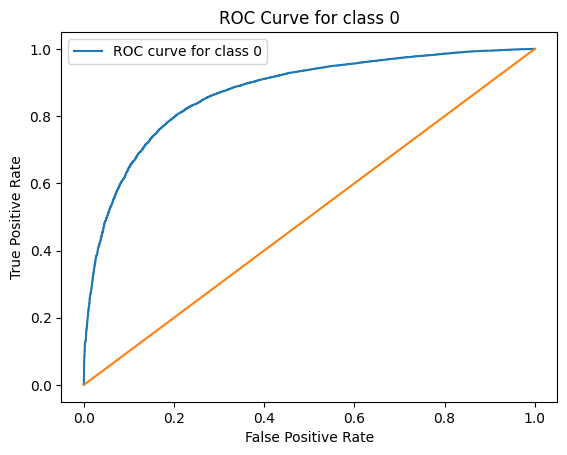

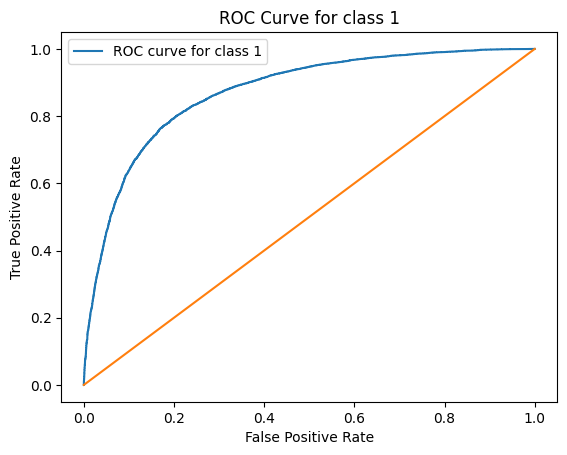

In [37]:
for i in range(2):
  plt.figure()
  plt.plot(fpr[i], tpr[i],label=f'ROC curve for class {i}')
  plt.plot([0, 1], [0, 1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for class {i}')
  plt.legend()
  plt.show()

In [43]:
#implementing regularization, dropout and early stopping
class PositionalEncoding_opt(nn.Module):
    def __init__(self, d_model, max_len=7000):
        super().__init__()
        #we are trying to generate a sequence of positions
        pos = torch.arange(max_len).unsqueeze(1)
        log_base = math.log(10000.0) / d_model
        temp = torch.arange(0, d_model, 2)
        exp = torch.exp(temp * -log_base)
        #defined a positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        #for the even indices in the matrix we are using sin
        pe[:, 0::2] = torch.sin(pos * exp)
        #and for the odd indices we are using cosine function
        pe[:, 1::2] = torch.cos(pos * exp)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
      #a forward pass function for the postional encoding
      x = x + self.pe[:, :x.size(1)]
      return x

class TransformerModel_opt(nn.Module):
    def __init__(self, vocab_size, num_classes,num_heads,embed_dime,hidden_dim,n_encoder_layers,n_decoder_layers,dropout_rate):
        super().__init__()
        self.embed_dim = embed_dime
        #embedding layer that is used for converting the input tokens to vectors of the embed_dim size
        self.embedding = nn.Embedding(vocab_size, self.embed_dim)
        #calling the positional enocder function
        self.pos_encoder = PositionalEncoding_opt(self.embed_dim)
        #defining the encoder layer of the transformer model
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_encoder_layers)
        #similarly defining the decoder layer of the transformer model
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=self.embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout_rate)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=n_decoder_layers)
        #a fully connected layer from the decoder output to the total number of classes
        self.fc_out = nn.Linear(self.embed_dim, num_classes)
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, src):
      #definined a forward pass for the transformer model
      cal = math.sqrt(self.embed_dim)
      src = self.embedding(src) * cal
      src = self.pos_encoder(src)
      src = self.dropout(src)
      mem = self.transformer_encoder(src)
      op = self.transformer_decoder(src, mem)
      op = op.mean(dim=1)
      op = self.dropout(op)
      op = self.fc_out(op)
      return op


In [44]:
from torch.optim.lr_scheduler import StepLR
dropout_rate = 0.3
model_opt = TransformerModel_opt(vocab_size,num_classes,num_heads,embed_dime,hidden_dim,n_encoder_layers,n_decoder_layers,dropout_rate)
optimizer = optim.Adam(model_opt.parameters(), lr=learning_rate,weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [45]:
model_opt.to(device)

TransformerModel_opt(
  (embedding): Embedding(196307, 256)
  (pos_encoder): PositionalEncoding_opt()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=512, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.3, inplace=False)
    (dropout2): Dropout(p=0.3, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out

In [46]:
train_loss_opt, train_accuracy_opt, val_loss_opt, val_accuracy_opt, test_accuracy_opt, conf_matrix_opt, class_report_opt, true_labels_opt,test_scores_opt = train_test_val_cal(model_opt,num_epochs=5)

Epoch 1/5, Training Loss: 0.6858287594084547, Training Accuracy: 0.55195, Validation Loss: 0.6732105900304386, Validation Accuracy: 0.57975
Epoch 2/5, Training Loss: 0.6576880546393933, Training Accuracy: 0.6113166666666666, Validation Loss: 0.6148718041352952, Validation Accuracy: 0.68315
Epoch 3/5, Training Loss: 0.6196157632987382, Training Accuracy: 0.6743, Validation Loss: 0.5765565419539856, Validation Accuracy: 0.7077
Epoch 4/5, Training Loss: 0.58919745292872, Training Accuracy: 0.7025, Validation Loss: 0.5412538713350082, Validation Accuracy: 0.7371
Epoch 5/5, Training Loss: 0.5658580592192058, Training Accuracy: 0.7221833333333333, Validation Loss: 0.5211560503362467, Validation Accuracy: 0.74115
Test Accuracy: 0.74155


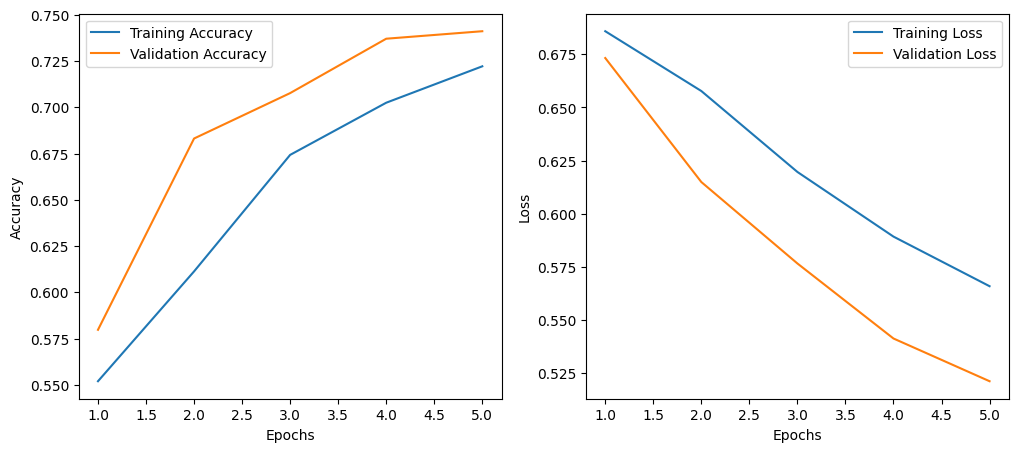

In [47]:
import matplotlib.pyplot as plt
num_epochs = 5
# Plot training and validation accuracy over time for base model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1),train_accuracy_opt, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1),val_accuracy_opt, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss over time for base model
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1),train_loss_opt, label='Training Loss')
plt.plot(range(1, num_epochs + 1),val_loss_opt, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


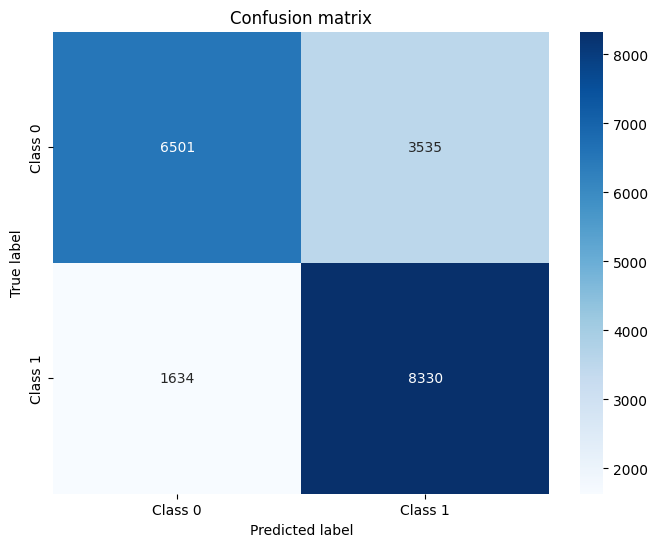

In [48]:
plt.figure(figsize=(8, 6))
class_labels = ['Class 0', 'Class 1']
sns.heatmap(conf_matrix_opt, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion matrix")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [49]:
print(class_report_opt)

              precision    recall  f1-score   support

           0       0.80      0.65      0.72     10036
           1       0.70      0.84      0.76      9964

    accuracy                           0.74     20000
   macro avg       0.75      0.74      0.74     20000
weighted avg       0.75      0.74      0.74     20000



In [50]:
true_labels_one_hot_opt = label_binarize(true_labels_opt, classes=[0, 1])
test_scores_opt = np.array(test_scores_opt)

fpr = dict()
tpr = dict()
roc_auc = dict()
if test_scores_opt.ndim == 1:
  test_scores_opt = test_scores_opt[:, np.newaxis]
if true_labels_one_hot_opt.shape[1] == 1:
  true_labels_one_hot_opt = np.hstack([1 - true_labels_one_hot_opt, true_labels_one_hot_opt])

for i in range(2):
  fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot_opt[:, i], test_scores_opt[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

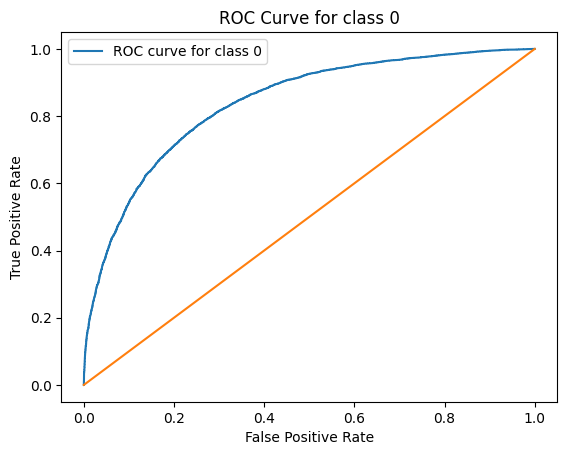

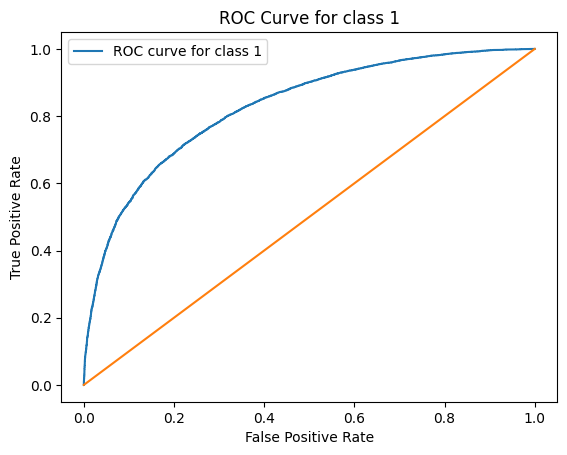

In [51]:
for i in range(2):
  plt.figure()
  plt.plot(fpr[i], tpr[i],label=f'ROC curve for class {i}')
  plt.plot([0, 1], [0, 1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for class {i}')
  plt.legend()
  plt.show()

In [53]:
#saving model weights
torch.save(model, 'model.pth')